In [132]:
import pandas as pd 
import numpy as np
import scipy.stats
import pylab 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [133]:
data15 = pd.read_csv("~/Documents/Data/NNRB/Finaldata/NN_Dataset.csv")
data15.head()

,Time,Delta,Damkohler,Sigma,CUM_Steam
0,0,-0.260848,0.123912,0.937022,25.2
1,1,-0.344876,0.116629,1.033851,26.9
2,2,-0.339656,0.115659,1.027957,27.9
3,3,-0.317045,0.126365,0.993998,28.6
4,4,-0.284570,0.122794,0.971008,25.3


<Axes: >

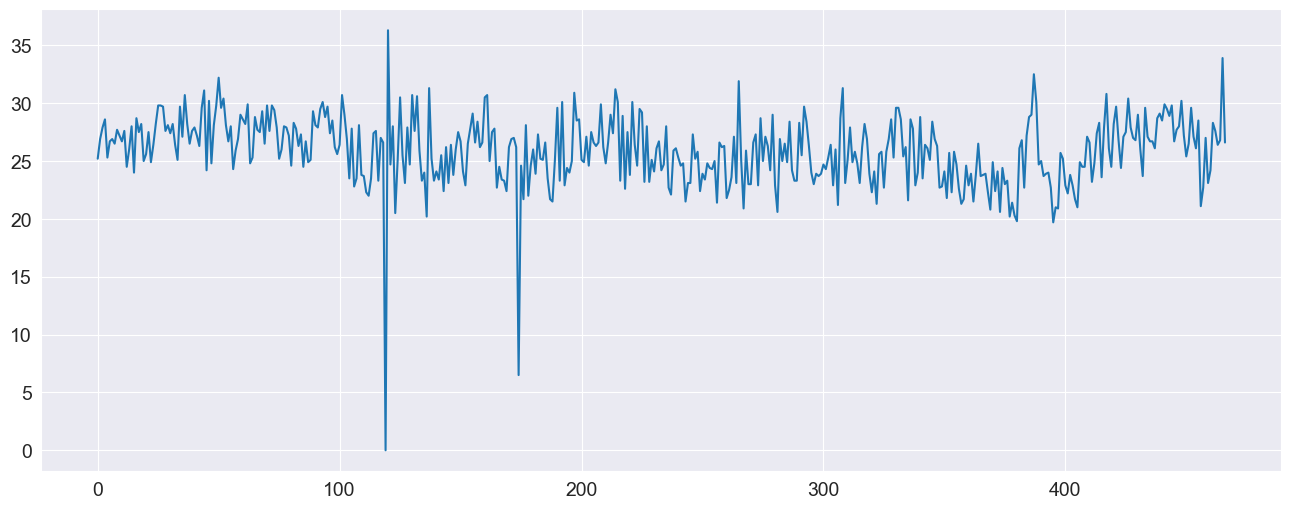

In [134]:
data15.CUM_Steam.plot()

## QQ Plot

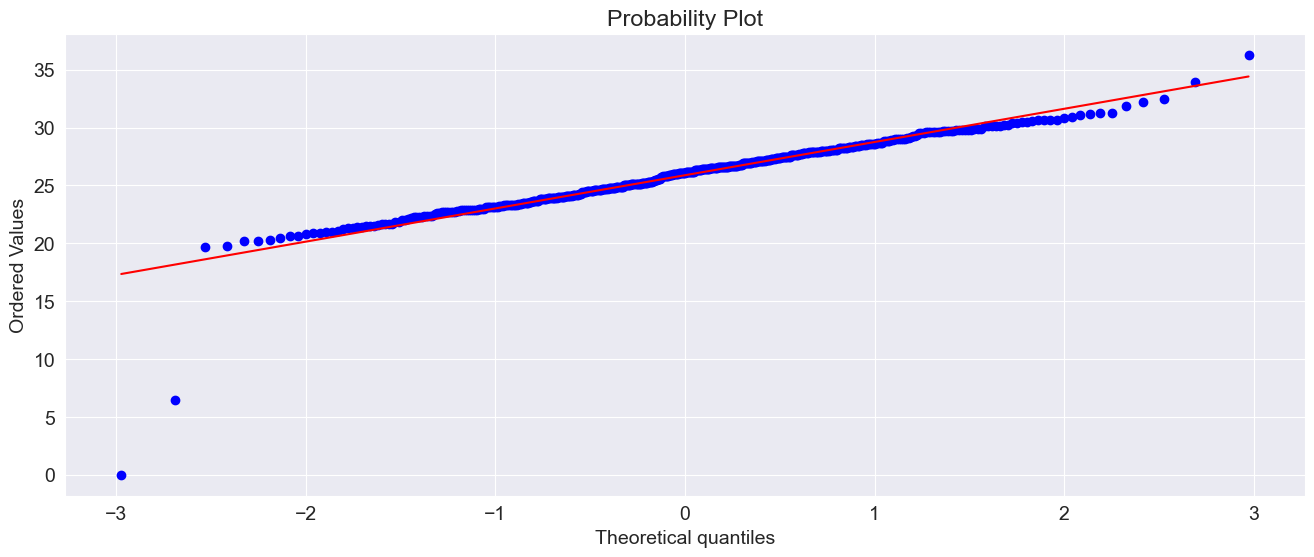

In [135]:
scipy.stats.probplot(data15.CUM_Steam, plot=pylab)
pylab.show()

In [136]:
data15.Time.describe()

count    467.000000
mean     233.000000
std      134.955548
min        0.000000
25%      116.500000
50%      233.000000
75%      349.500000
max      466.000000
Name: Time, dtype: float64

In [137]:
# Create a range of integers representing the time axis from 0 to 500
time_axis = range(0, len(data15))  # Assuming inclusive range from 0 to 500

# Multiply each integer by 60 to convert it to minutes
minutes = [t * 60 for t in time_axis]

# Convert the minutes to datetime format with 1-minute frequency
time_index = pd.date_range(start='2023-01-01', periods=len(minutes), freq='T')

# Assign the datetime index to the DataFrame
data15.index = time_index

# Drop the existing 'time' column
data15.drop(columns=['Time'], inplace=True)

# Rename the index to 'time'
data15.index.name = 'Time'

# Drop the existing 'Time' column if needed
data15_comp = data15.copy()

In [138]:
data15.head()

,Delta,Damkohler,Sigma,CUM_Steam
Time,,,,
2023-01-01 00:00:00,-0.260848,0.123912,0.937022,25.2
2023-01-01 00:01:00,-0.344876,0.116629,1.033851,26.9
2023-01-01 00:02:00,-0.339656,0.115659,1.027957,27.9
2023-01-01 00:03:00,-0.317045,0.126365,0.993998,28.6
2023-01-01 00:04:00,-0.284570,0.122794,0.971008,25.3


In [139]:
train_size = int(len(data15_comp)*0.8)

data15_train = data15_comp[:train_size]
data15_test = data15_comp[train_size:]

In [140]:
data15_train.tail()

,Delta,Damkohler,Sigma,CUM_Steam
Time,,,,
2023-01-01 06:08:00,-0.174143,0.146436,0.778894,22.3
2023-01-01 06:09:00,-0.073835,0.228220,0.688857,20.8
2023-01-01 06:10:00,-0.233377,0.144645,0.845320,24.9
2023-01-01 06:11:00,-0.211237,0.142652,0.822799,22.4
2023-01-01 06:12:00,-0.238641,0.130567,0.879021,24.1


In [141]:
data15_test.head

<bound method NDFrame.head of                         Delta  Damkohler     Sigma  CUM_Steam
Time                                                         
2023-01-01 06:13:00 -0.163482   0.147009  0.771365       20.6
2023-01-01 06:14:00 -0.043615   0.134034  0.769499       24.4
2023-01-01 06:15:00 -0.184182   0.148725  0.784049       23.0
2023-01-01 06:16:00 -0.171050   0.101626  0.829997       23.3
2023-01-01 06:17:00 -0.076865   0.236652  0.679180       20.2
2023-01-01 06:18:00 -0.144005   0.165673  0.740203       21.4
2023-01-01 06:19:00 -0.159784   0.146042  0.770056       20.3
2023-01-01 06:20:00 -0.087818   0.194628  0.713164       19.8
2023-01-01 06:21:00 -0.479947   0.158274  1.102100       26.1
2023-01-01 06:22:00 -0.246712   0.143324  0.876546       26.8
2023-01-01 06:23:00 -0.273946   0.160027  0.911710       22.7
2023-01-01 06:24:00 -0.298468   0.136718  0.973204       27.2
2023-01-01 06:25:00 -0.483927   0.127292  1.171332       28.8
2023-01-01 06:26:00 -0.255589   0.084275

### Stationarity

In [142]:
sts.adfuller(data15_comp.CUM_Steam)

(-4.722895902345563,
 7.620206279563713e-05,
 6,
 460,
 {'1%': -3.44464601455782,
  '5%': -2.867843681679954,
  '10%': -2.570127622873346},
 2234.613997644517)

### ACF

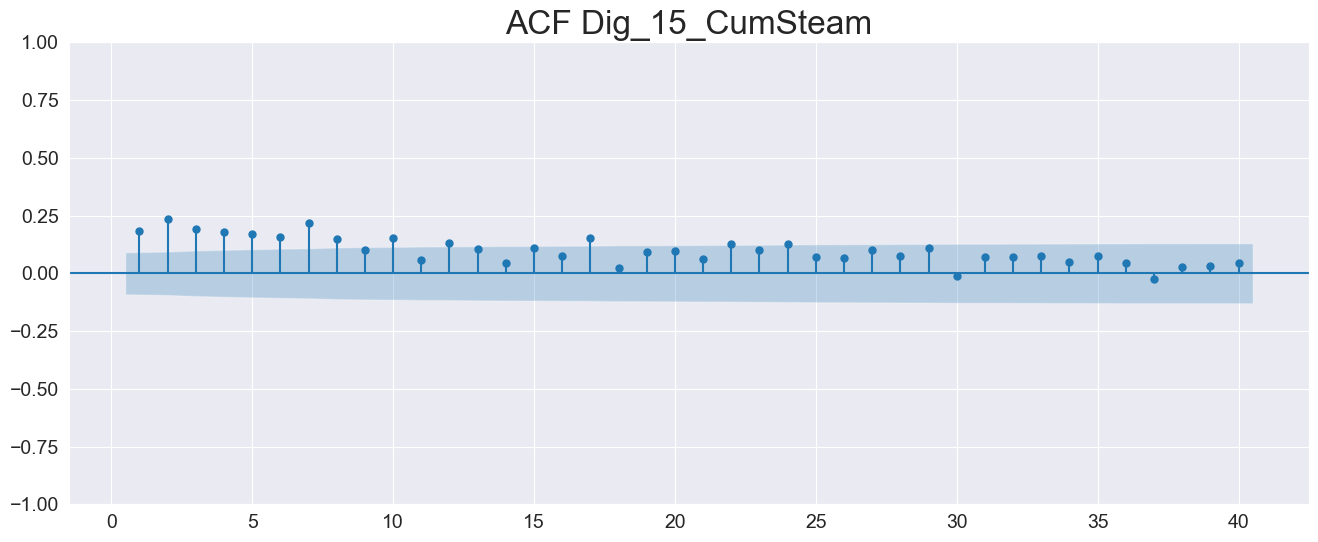

In [143]:
sgt.plot_acf(data15.CUM_Steam, lags = 40, zero = False)
plt.title("ACF Dig_15_CumSteam", size = 24)
plt.show()

### PACF

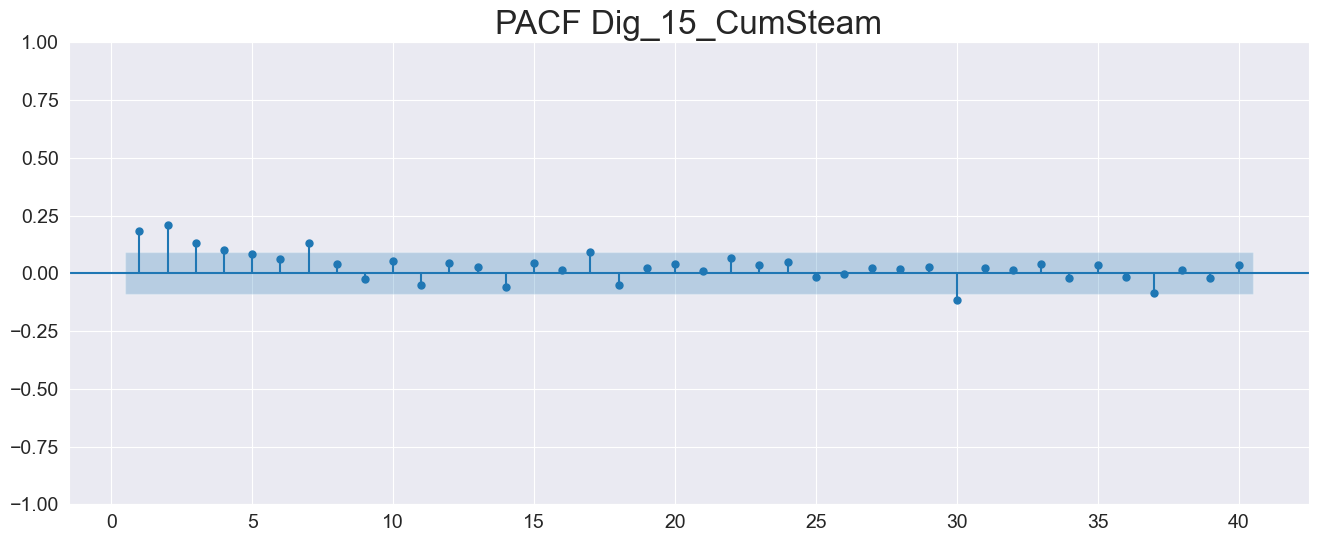

In [144]:
sgt.plot_pacf(data15.CUM_Steam, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Dig_15_CumSteam", size = 24)
plt.show()

In [145]:
#LLR Test
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)

    return p

### AR Models

In [146]:
#AR1
model_ar1 = ARIMA(data15_train.CUM_Steam, order=(1, 0, 0))
results_ar1 = model_ar1.fit()
print(results_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  373
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -942.344
Date:                Tue, 05 Mar 2024   AIC                           1890.688
Time:                        14:41:24   BIC                           1902.453
Sample:                    01-01-2023   HQIC                          1895.360
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8731      0.205    125.976      0.000      25.471      26.276
ar.L1          0.0871      0.028      3.077      0.002       0.032       0.143
sigma2         9.1603      0.259     35.422      0.0

In [147]:
#AR2
model_ar2 = ARIMA(data15_train.CUM_Steam, order=(2, 0, 0))
results_ar2 = model_ar2.fit()
print(results_ar2.summary())
print("LLR test: " + str(LLR_test(model_ar1, model_ar2)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  373
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -935.319
Date:                Tue, 05 Mar 2024   AIC                           1878.637
Time:                        14:41:24   BIC                           1894.324
Sample:                    01-01-2023   HQIC                          1884.866
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8694      0.253    102.341      0.000      25.374      26.365
ar.L1          0.0706      0.028      2.491      0.013       0.015       0.126
ar.L2          0.1922      0.061      3.166      0.0

In [148]:
#AR3
model_ar3 = ARIMA(data15_train.CUM_Steam, order=(3, 0, 0))
results_ar3 = model_ar3.fit()
print(results_ar3.summary())
print("LLR test: " + str(LLR_test(model_ar2, model_ar3)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  373
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -933.557
Date:                Tue, 05 Mar 2024   AIC                           1877.114
Time:                        14:41:25   BIC                           1896.722
Sample:                    01-01-2023   HQIC                          1884.900
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8678      0.278     93.049      0.000      25.323      26.413
ar.L1          0.0517      0.029      1.777      0.076      -0.005       0.109
ar.L2          0.1856      0.060      3.105      0.0

In [149]:
#ARMA
model_arma21 = ARIMA(data15_train.CUM_Steam, order=(2, 0, 2))
results_arma = model_arma21.fit()
print(results_arma.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  373
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -924.850
Date:                Tue, 05 Mar 2024   AIC                           1861.700
Time:                        14:41:26   BIC                           1885.229
Sample:                    01-01-2023   HQIC                          1871.043
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7963      0.625     41.291      0.000      24.572      27.021
ar.L1          0.5551      0.475      1.167      0.243      -0.377       1.487
ar.L2          0.3961      0.467      0.848      0.3

In [150]:
#ARMA
model_arma11 = ARIMA(data15_train.CUM_Steam, order=(1, 0, 1))
results_arma = model_arma11.fit()
print(results_arma.summary())
print("LLR test: " + str(LLR_test(model_arma21, model_arma11)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  373
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -926.712
Date:                Tue, 05 Mar 2024   AIC                           1861.424
Time:                        14:41:26   BIC                           1877.110
Sample:                    01-01-2023   HQIC                          1867.653
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7882      0.675     38.218      0.000      24.466      27.111
ar.L1          0.9727      0.027     35.642      0.000       0.919       1.026
ma.L1         -0.8969      0.035    -25.416      0.0

In [151]:
#************************** ARIMA 111 IS THE CORRECT MODEL ******************************#

#ARIMA111

model_arima111 = ARIMA(data15_train.CUM_Steam, order=(1, 1, 1))
results_arima111 = model_arima111.fit()
print(results_arima111.summary())
print("LLR test: " + str(LLR_test(model_arima111, model_arma11)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  373
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -925.477
Date:                Tue, 05 Mar 2024   AIC                           1856.954
Time:                        14:41:27   BIC                           1868.711
Sample:                    01-01-2023   HQIC                          1861.623
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0878      0.047     -1.874      0.061      -0.180       0.004
ma.L1         -0.9068      0.028    -32.527      0.000      -0.961      -0.852
sigma2         8.4378      0.231     36.605      0.0

In [152]:
#ARIMA
model_arima121 = ARIMA(data15_train.CUM_Steam, order=(1, 2, 1))
results_arima121 = model_arima121.fit()
print(results_arima111.summary())
print("LLR test: " + str(LLR_test(model_arima111, model_arima121)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  373
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -925.477
Date:                Tue, 05 Mar 2024   AIC                           1856.954
Time:                        14:41:28   BIC                           1868.711
Sample:                    01-01-2023   HQIC                          1861.623
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0878      0.047     -1.874      0.061      -0.180       0.004
ma.L1         -0.9068      0.028    -32.527      0.000      -0.961      -0.852
sigma2         8.4378      0.231     36.605      0.0

### ARIMAX

In [153]:
# Define exogenous variables
exog_vars = data15_train[['Delta', 'Damkohler', 'Sigma']]

# Fit AutoARIMA model with exogenous variables
model_arimax = ARIMA(data15_train['CUM_Steam'], exog=exog_vars, order=(1,1,1))  # Modify 'm' based on the seasonality of your data
res_arimax = model_arimax.fit()
res_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CUM_Steam   No. Observations:                  373
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -744.944
Date:                Tue, 05 Mar 2024   AIC                           1501.888
Time:                        14:41:29   BIC                           1525.401
Sample:                    01-01-2023   HQIC                          1511.226
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Delta          0.0326      1.028      0.032      0.975      -1.982       2.047
Damkohler      7.3985      0.721     10.255      0.000       5.984       8.813
Sigma         19.0097      0.625     30.438      0.000      17.786      20.234
ar.L1          0.1374      0.048      2.849      0.004       0.043       0.232
ma.L1         -0.9771      0.010    -95.790      0.000      -0.997      -0.957
sigma2         3.1886      0.169     18.893      0.000       2.858       3.519
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               396.23
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Plotting

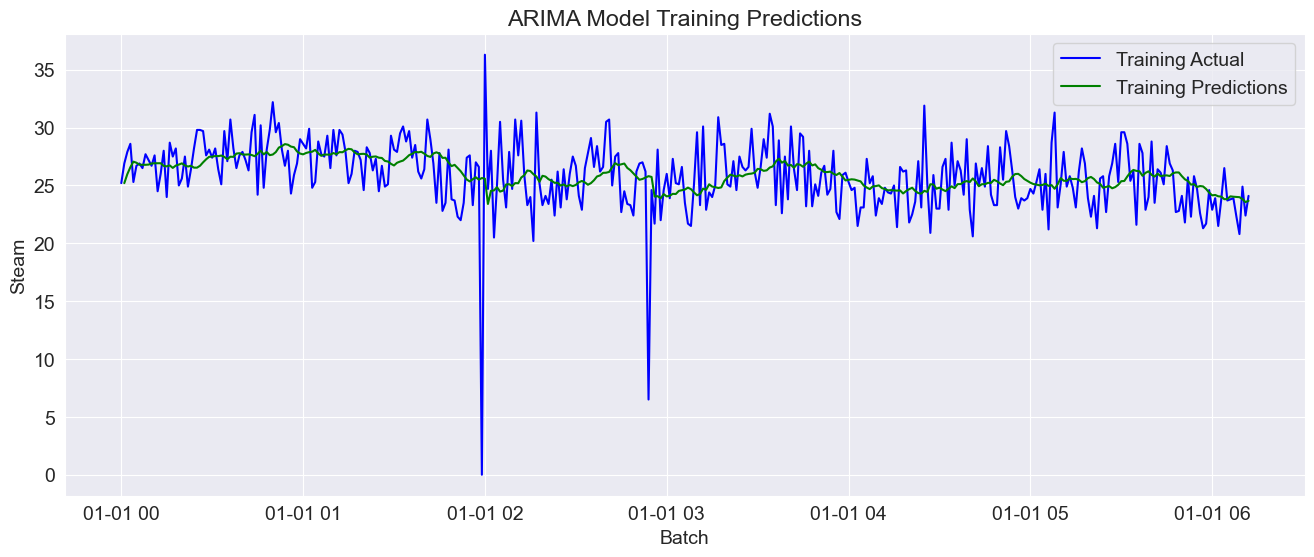

In [154]:
start_date = '2023-01-01 06:13:00'
end_date = '2023-01-01 07:46:00'

# Make predictions on training dataset
train_predictions = pd.DataFrame(results_arima111.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
test_predictions = pd.DataFrame(results_arima111.predict(start=start_date, end=end_date))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='Training Predictions')

# Add labels and legend
plt.title('ARIMA Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### Training Performance

In [155]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

# Calculate Accuracy (optional, depending on the problem)
accuracy = (1 - (mae / np.mean(data15_train['CUM_Steam']))) * 100
print('mae', mae)
print('rmse', rmse)
print('accuracy', accuracy)

mae 2.066392608271844
rmse 3.1825877750530736
accuracy 92.0134657967692


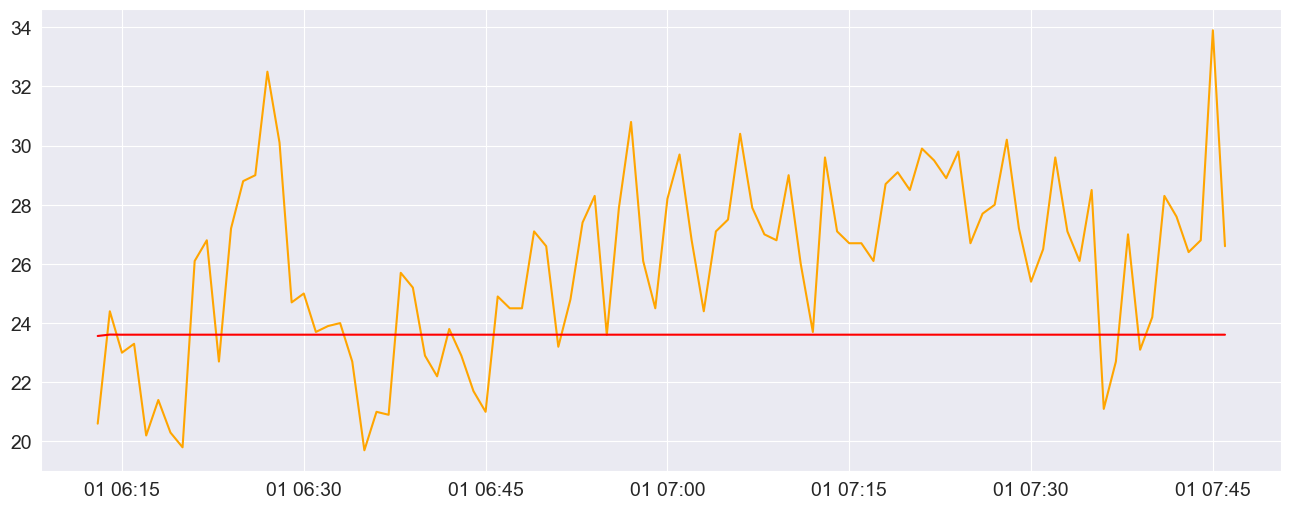

In [156]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### Test Performance

In [157]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], test_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], test_predictions['predicted_mean']))

# Calculate Accuracy (optional, depending on the problem)
accuracy = (1 - (mae / np.mean(data15_test['CUM_Steam']))) * 100
print('mae', mae)
print('rmse', rmse)
print('accuracy', accuracy)

mae 3.1570407386717445
rmse 3.784206489931475
accuracy 87.82365708866142


### ARIMAX Model Plotting

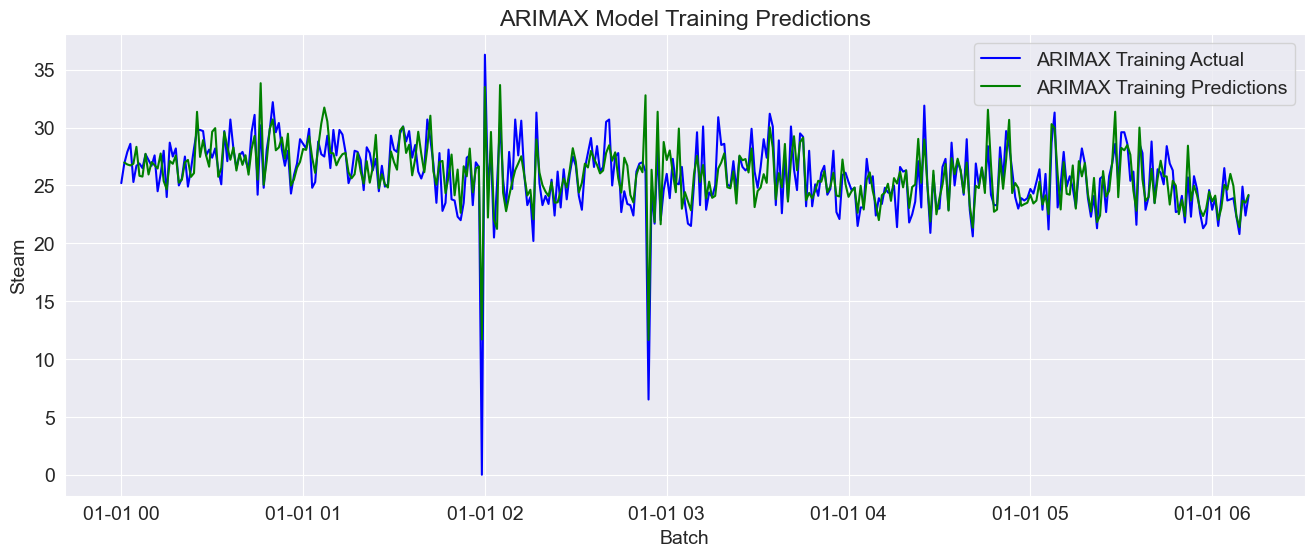

In [158]:
start_date = '2023-01-01 06:13:00'
end_date = '2023-01-01 07:46:00'
exog_vars_test = data15_test[['Delta', 'Damkohler', 'Sigma']]

# Make predictions on training dataset
train_predictions = pd.DataFrame(res_arimax.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
arimax_test_predictions = pd.DataFrame(res_arimax.predict(start=start_date, end=end_date, exog=exog_vars_test))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='ARIMAX Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='ARIMAX Training Predictions')

# Add labels and legend
plt.title('ARIMAX Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### ARIMAX Training Performance

In [159]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

# Calculate Accuracy (optional, depending on the problem)
accuracy = (1 - (mae / np.mean(data15_test['CUM_Steam']))) * 100
print('mae', mae)
print('rmse', rmse)
print('accuracy', accuracy)

mae 1.3454488169210455
rmse 1.8176818815766036
accuracy 94.8107587070992


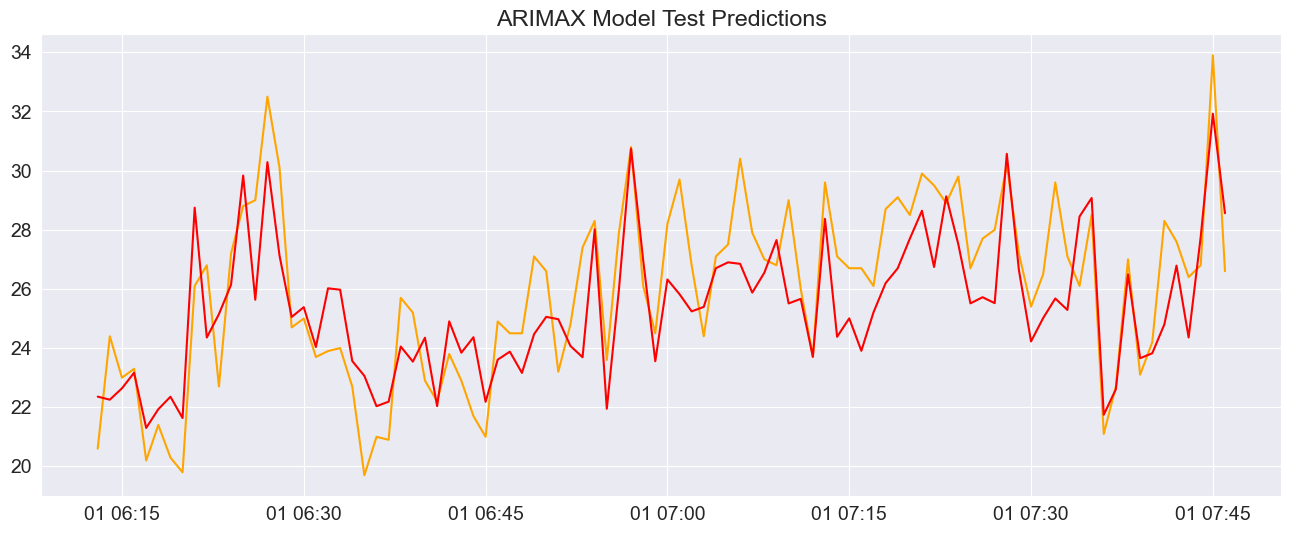

In [160]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, arimax_test_predictions['predicted_mean'], color='red', label='Forecast')

# Add labels and legend
plt.title('ARIMAX Model Test Predictions')

# Show plot
plt.show()

### ARIMAX Test Performance

In [161]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean']))

# Calculate Accuracy (optional, depending on the problem)
accuracy = (1 - (mae / np.mean(data15_test['CUM_Steam']))) * 100
print('mae', mae)
print('rmse', rmse)
print('accuracy', accuracy)

mae 1.520421837710917
rmse 1.8175792153069161
accuracy 94.13590789656877
